<html>
<h3>Removing top layer of efficient net and loading our own classification layer</h3>

references:<br>
<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/">Tensorflow Documentation - Layers</a><br>
<a href="https://arxiv.org/pdf/1905.11946.pdf">Efficient Net and how it works</a><br>
<a href="https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/">Keras example for fine tuning</a><br>
<a href="https://www.tensorflow.org/guide/keras/train_and_evaluate">Tensorflow Documentation - Compiling and Evaluating</a><br>
<a href="https://keras.io/api/optimizers/">Keras Documentation - Optimisers</a><br>
<a href="https://keras.io/api/metrics/">Keras Documentation - Metrics</a><br>
<a href="https://keras.io/api/losses/">Keras Documentation - Losses</a><br>
<a href="https://keras.io/api/preprocessing/image/">Keras Documentation - Image Preprocess</a><br>
</html>

In [1]:
# importing required packages

from tensorflow.keras.applications import EfficientNetB0 as enet
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import ResizeMethod

import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import io
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd

# for model plot
from tensorflow.keras.utils import plot_model

# for image sampling
import os
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline

In [2]:
# loading pretrained model, setting input shape
inputs = (224, 224, 3)

# Selecting a topless model (sounds damn good...)
basemodel = enet(include_top=False, input_shape=inputs, weights="imagenet")

# locking the trained weights (freezing?)
basemodel.trainable = False 

# checking out how its like
basemodel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [3]:
# plot_model(basemodel, to_file='model.png',show_shapes=True, show_layer_names=True)

In [4]:
# to rebuild top layer for our own classification

dropout_rate = 0.4 #i_dunno_yet - supposed to prevent overfit
types = 2 #currently only mask and no mask 

# building up the model in sequence
model = models.Sequential()

# loading the original topless model
model.add(basemodel)

# adding top layers 
model.add(layers.GlobalMaxPooling2D(name="gap"))

model.add(layers.Dropout(dropout_rate, name="drout"))

model.add(layers.Dense(types, activation="softmax", name="classdense"))

# view the assembled model
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
drout (Dropout)              (None, 1280)              0         
_________________________________________________________________
classdense (Dense)           (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


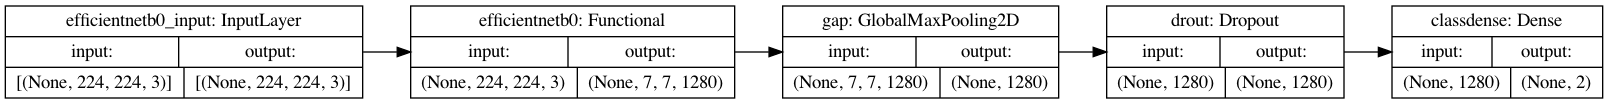

In [5]:
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True, rankdir ="LR")

In [6]:

# settings #
train_folder = "../data/training"
validation_folder = "../data/validation"
test_folder = "../data1/test"
save_folder = "../data/saved"
height = 224
width = 224
num_train = 800
num_valid = 200
batch_size = 16
v_batch_size = 8
t_batch_size = 4
epochs_to_run = 2
learning_rate = 2e-2
seed = 1    # to sample same augmented images
max_sample = 9    # max sampling must be perfect square  i.e. 9, 16, 25 etc.
fig_size = 8

In [7]:
def show_grid(x_generate, count):
    # create a grid of countxcount images

    grid = round(math.sqrt(count))
    
    plt.figure(figsize=(fig_size,fig_size))
    for i in range(0,count):
        batch = x_generate.next()
        ax = plt.subplot(grid, grid, i + 1)
        image = batch[0][0].astype('uint8')
        plt.title(batch[1][0].astype("int"))
        plt.tight_layout()
        plt.imshow(image)

    print("Note: With Mask => [1 0],  Without Mask => [0 1]")
    # show the plot
    plt.show()

Found 1600 images belonging to 2 classes.
Sampling original images ...
Note: With Mask => [1 0],  Without Mask => [0 1]


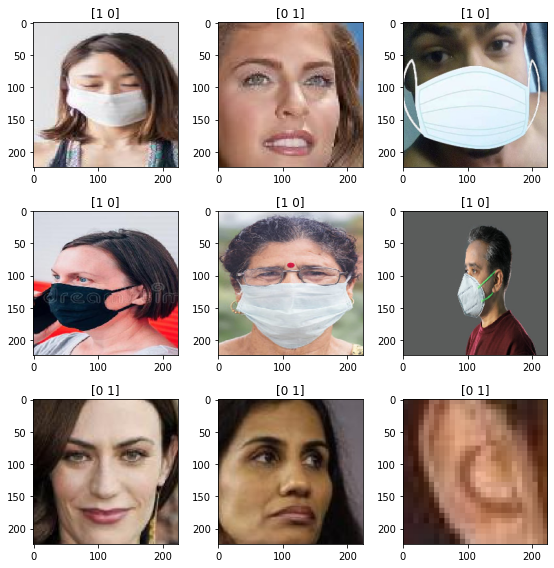

In [8]:
# load data

orig_tf = ImageDataGenerator()

# using keras image generator, disable save_to_dir if not required
orig_generate = orig_tf.flow_from_directory(train_folder, target_size = (height, width), #save_to_dir = save_folder,
                                              shuffle = True, batch_size = batch_size, class_mode="categorical", seed = seed)
print("Sampling original images ...")
show_grid(orig_generate, max_sample)

Found 1600 images belonging to 2 classes.
Sampling augmented images ...
Note: With Mask => [1 0],  Without Mask => [0 1]


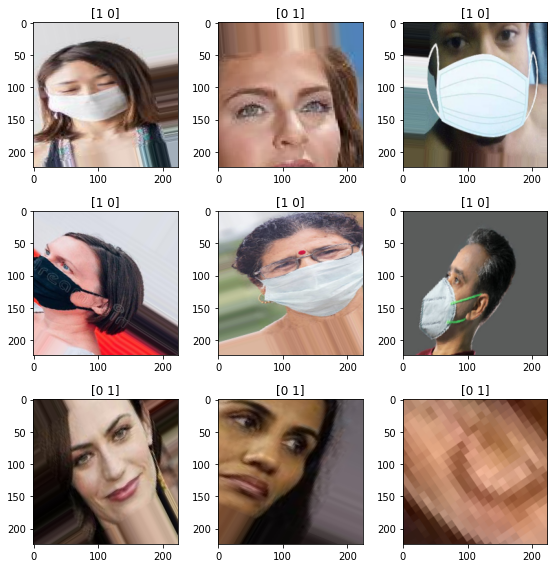

In [9]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=35,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.3)

train_tf = ImageDataGenerator(**data_gen_args)

# using keras image generator, disable save_to_dir if not required
train_generate = train_tf.flow_from_directory(train_folder, target_size = (height, width), #save_to_dir = save_folder,
                                              shuffle = True, batch_size = batch_size, class_mode="categorical", seed = seed)

print("Sampling augmented images ...")
show_grid(train_generate, max_sample)




In [10]:
# normalise 255 to 0-1
validate_tf = ImageDataGenerator()#rescale = 1.0 / 255)

validate_generate = validate_tf.flow_from_directory(validation_folder, target_size = (height, width),                                                                                shuffle = True, batch_size = v_batch_size, class_mode="categorical")

model.compile(loss="categorical_crossentropy", optimizer = keras.optimizers.Adam(lr=learning_rate), metrics = ["accuracy"])

history = model.fit(train_generate, epochs = epochs_to_run, steps_per_epoch = batch_size,
                    validation_data = validate_generate, validation_steps = v_batch_size)

Found 400 images belonging to 2 classes.
Epoch 1/2
16/16 [==============================] - 20s 904ms/step - loss: 17.4698 - accuracy: 0.5951 - val_loss: 1.3905 - val_accuracy: 0.9062
Epoch 2/2
16/16 [==============================] - 12s 777ms/step - loss: 0.8184 - accuracy: 0.9489 - val_loss: 0.3419 - val_accuracy: 0.9844


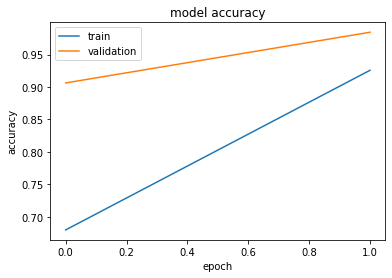

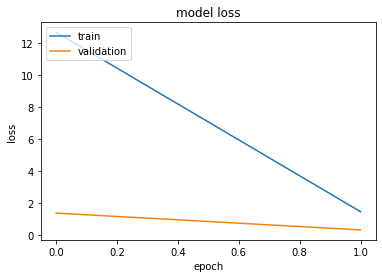

In [11]:
# to-do: fit the training set into the fine-tuned model to see if theres improvements
def plot_hist(hist, measure):
    v_measure = "val_" + measure

    plt.plot(hist.history[measure])
    plt.plot(hist.history[v_measure])
    plt.title("model " + measure)
    plt.ylabel(measure)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(history, "accuracy")
plot_hist(history, "loss")

Found 400 images belonging to 2 classes.
Evaluate on validation data
50/50 [==============================] - 15s 299ms/step - loss: 0.6285 - accuracy: 0.9775
test loss, validation data set acc: [0.6285436153411865, 0.9775000214576721] 
Sampling evaluation images ...
Note: With Mask => [1 0],  Without Mask => [0 1]


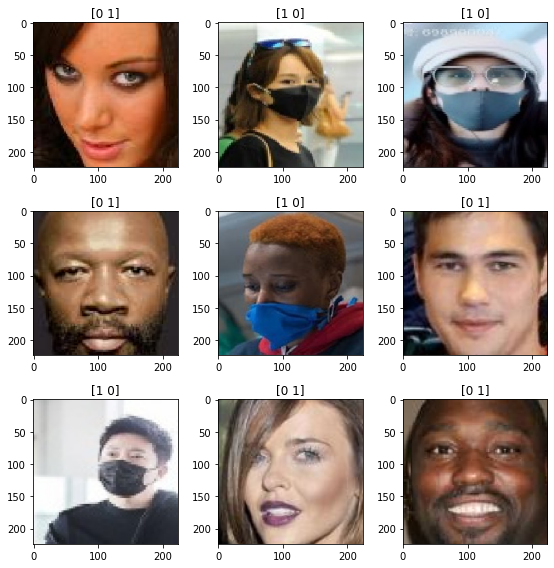

In [12]:
# Evaluate the model on the validation data using `evaluate`
eval_tf = ImageDataGenerator()

eval_generate = eval_tf.flow_from_directory(validation_folder, target_size = (height, width), 
                                            shuffle = True, batch_size = v_batch_size, class_mode="categorical")
print("Evaluate on validation data")
results = model.evaluate(eval_generate)
print("test loss, validation data set acc:", results, "\r")

print("Sampling evaluation images ...")
show_grid(eval_generate, max_sample)


Found 15 images belonging to 1 classes.
Sampling test images ...
Note: With Mask => [1 0],  Without Mask => [0 1]


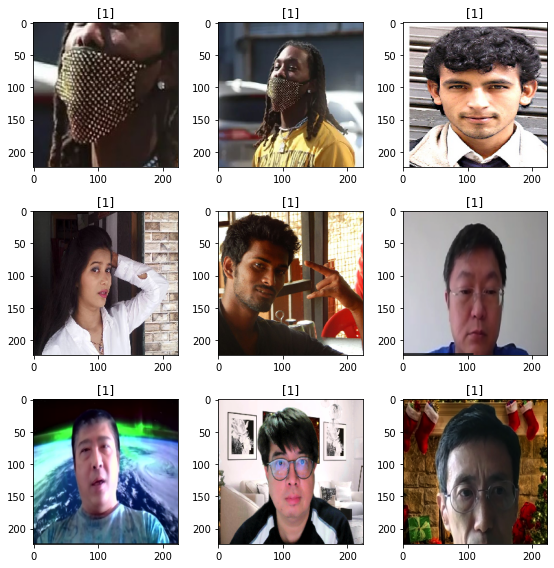

In [20]:
# Evaluate the model on the test data using `evaluate`
test_tf = ImageDataGenerator()

test_generate = test_tf.flow_from_directory(test_folder, target_size = (height, width), 
                                            shuffle = False,batch_size = 1, class_mode="categorical")

print("Sampling test images ...")
show_grid(test_generate, max_sample)
# print("test loss, test data set accuracy:", results, "\r")
# dict(zip(model.metrics_names, results))

In [18]:
# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions for test set")

test_generate.reset()
pred = model.predict(test_generate)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generate.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generate.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

Generate predictions for test set


In [19]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     15 non-null     object
 1   Predictions  15 non-null     object
dtypes: object(2)
memory usage: 368.0+ bytes
